In [1]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e5, recombination_rate=1e-8, random_seed=40)

In [3]:
ts.num_trees

10

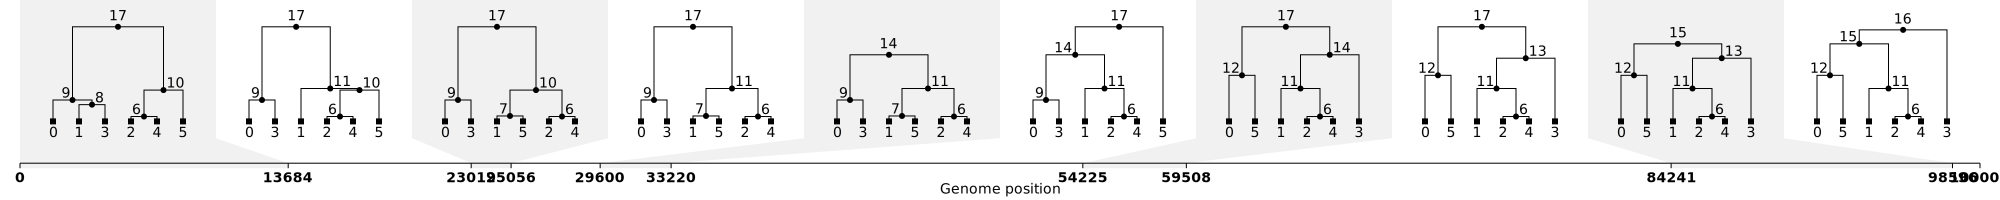

In [4]:
SVG(ts.draw_svg())

In [61]:
# from https://github.com/tskit-dev/tskit/issues/2118

def mirror_coordinates(ts):
    """
    Returns a copy of the specified tables in which all
    coordinates x are transformed into L - x.
    """
    L = ts.sequence_length
    tables = ts.dump_tables()
    left = tables.edges.left
    right = tables.edges.right
    tables.edges.left = L - right
    tables.edges.right = L - left
    tables.sites.position = L - tables.sites.position - 1
    tables.sort()
    return tables.tree_sequence()

def forward_extend(ts, verbose=False, return_tables=False):
    edgediffs = ts.edge_diffs()
    # skip first tree
    num_edges = np.full(ts.num_nodes, 0)
    (_, edges_out, edges_in) = next(edgediffs)
    assert len(edges_out) == 0
    for e in edges_in:
        num_edges[e.parent] += 1
        num_edges[e.child] += 1


    t = ts.tables
    edges = t.edges
    new_left = edges.left
    new_right = edges.right

    pending_out = []
    pending_in = []
    for (interval, edges_out, edges_in) in edgediffs:
        edges_out.extend(pending_out)
        edges_in.extend(pending_in)
        # first update number of referring edges to what will happen after these are removed/added
        for e in edges_out:
            num_edges[e.parent] -= 1
            num_edges[e.child] -=1
        for e in edges_in:
            num_edges[e.parent] += 1
            num_edges[e.child] +=1
        print(num_edges)
        assert np.all(num_edges >= 0)
        pending_out = []
        pending_in = []
        extended = [False for _ in edges_out]
        for j1, e1 in enumerate(edges_out):
            if not extended[j1]:
                for j2, e2 in enumerate(edges_out):
                    if not extended[j2]:
                        # need the intermediate node to not be present in the new tree
                        if (e1.parent == e2.child) and (num_edges[e2.child] == 0):
                            for e_in in edges_in:
                                if e_in.right > interval.left:
                                    if e1.child == e_in.child and e2.parent == e_in.parent:
                                        # extend e2->e1 and postpone e_in
                                        # print("     ", interval, e1.child, "-", e1.parent, "-", e2.parent, " -> ", e_in)
                                        if verbose:
                                            print("ping!!", e1.id, "+", e2.id, "=", e_in.id)
                                        # extend e1 and e2, postpone e_in
                                        extended[j1] = True
                                        extended[j2] = True
                                        pending_out.extend([e1, e2])
                                        pending_in.append(e_in)
                                        new_right[e1.id] = interval.right
                                        new_right[e2.id] = interval.right
                                        new_left[e_in.id] = interval.right
                                        # amend num_edges: the intermediate node has 2 edges instead of 1
                                        num_edges[e1.parent] += 1
    keep = new_left < new_right
    edges.set_columns(
        left=new_left[keep],
        right=new_right[keep],
        parent=edges.parent[keep],
        child=edges.child[keep])
    if return_tables:
        return t
    else:
        return t.tree_sequence()


def extend_edges(ts, max_iter=100, verbose=False):
    num_edges = [ts.num_edges]
    for _ in range(max_iter):
        if verbose:
            print("Forwards")
        ts = forward_extend(ts, verbose=verbose)
        ts = mirror_coordinates(ts)
        if verbose:
            print("Reverse")
        ts = forward_extend(ts, verbose=verbose)
        ts = mirror_coordinates(ts)
        if ts.num_edges == num_edges[-1]:
            break
        else:
            num_edges.append(ts.num_edges)
    return ts, num_edges

ping!! 8 + 14 = 11
ping!! 6 + 12 = 10
ping!! 9 + 13 = 11
ping!! 6 + 12 = 10
[23, 20]


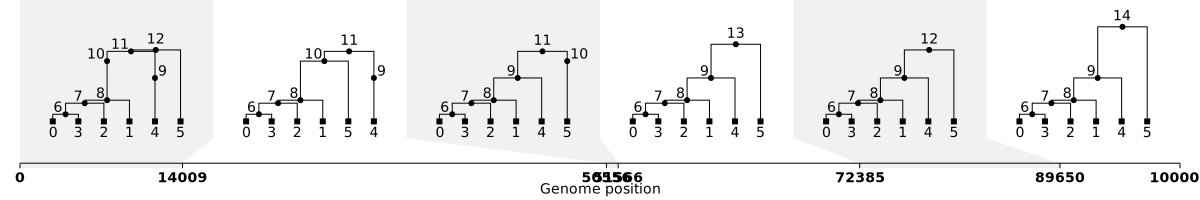

In [45]:
new_ts, num_edges = extend_edges(ts, verbose=True)
print(num_edges)
SVG(new_ts.draw_svg())

In [8]:
def verify_extending(ts):
    ets, num_edges = extend_edges(ts)
    sts = ets.simplify()
    sts.tables.assert_equals(ts.tables, ignore_provenance=True)
    # print(num_edges)
    
verify_extending(ts)

In [22]:
for seed in range(1, 100000):
    ts = msprime.sim_ancestry(3, population_size=2000, sequence_length=1e5, recombination_rate=1e-8, random_seed=seed)
    try:
        verify_extending(ts)
    except:
        print(seed)
        break

1379


In [62]:
ts = msprime.sim_ancestry(3, population_size=2000, sequence_length=1e5, recombination_rate=1e-8, random_seed=1379)
ts = forward_extend(ts, verbose=False)
ts = mirror_coordinates(ts)
ts = forward_extend(ts, verbose=False)
ts = mirror_coordinates(ts)
t = forward_extend(ts, verbose=True, return_tables=True)

[1 1 1 1 1 1 3 3 3 3 0 2 0 0]
[1 1 1 1 1 1 3 3 0 3 2 2 0 0]
[ 1  1  1  1  1  1  3  3 -1  3 -1  3  2  0]


AssertionError: 

In [33]:
print(t)

TableCollection

Sequence Length: 100000.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤════════╗
║id│flags│location│parents│metadata║
╠══╪═════╪════════╪═══════╪════════╣
║0 │    0│        │       │     b''║
║1 │    0│        │       │     b''║
║2 │    0│        │       │     b''║
╚══╧═════╧════════╧═══════╧════════╝

Nodes
╔══╤═════╤══════════╤══════════╤═════════════╤════════╗
║id│flags│population│individual│time         │metadata║
╠══╪═════╪══════════╪══════════╪═════════════╪════════╣
║0 │    1│         0│         0│   0.00000000│     b''║
║1 │    1│         0│         0│   0.00000000│     b''║
║2 │    1│         0│         1│   0.00000000│     b''║
║3 │    1│         0│         1│   0.00000000│     b''║
║4 │    1│         0│         2│   0.00000000│     b''║
║5 │    1│         0│         2│   0.00000000│     b''║
║6 │    0│         0│        -1│  55.66920767│     b''║
║7 │    0│         0│        -1│ 832.63424893│     b''║
║8 │    0│         0│   

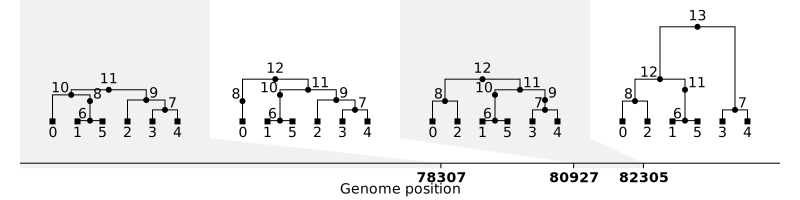

In [38]:
SVG(ts.draw_svg(x_lim=(7e4, 8.5e4)))

In [36]:
help(ts.draw_svg)

Help on method draw_svg in module tskit.trees:

draw_svg(path=None, *, size=None, x_scale=None, time_scale=None, tree_height_scale=None, node_labels=None, mutation_labels=None, root_svg_attributes=None, style=None, order=None, force_root_branch=None, symbol_size=None, x_axis=None, x_label=None, x_lim=None, y_axis=None, y_label=None, y_ticks=None, y_gridlines=None, **kwargs) method of tskit.trees.TreeSequence instance
    Return an SVG representation of a tree sequence. See the
    :ref:`visualization tutorial<tutorials:sec_tskit_viz>` for more details.
    
    :param str path: The path to the file to write the output. If None, do not write
        to file.
    :param size: A tuple of (width, height) giving the width and height of the
        produced SVG drawing in abstract user units (usually interpreted as pixels on
        display).
    :type size: tuple(int, int)
    :param str x_scale: Control how the X axis is drawn. If "physical" (the default)
        the axis scales linearly w

In [ ]:
Svals = [100, 1000, 10000]
Lvals = np.linspace(1e4, 3e6, 31)
num_edge_lists = {}
for S in Svals:
    nel = []
    for L in Lvals:
        ts = msprime.sim_ancestry(
            1000, 
            population_size=1000,
            sequence_length=int(L),
            recombination_rate=1e-8,
        )
        ets, num_edges = extend_edges(ts)
        nel.append(num_edges)
    num_edge_lists[S] = nel

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

for S in Svals:
    reduction = [x[-1] / x[0] for x in num_edge_lists[S]]
    ax.plot(Lvals, reduction, label=f"num samples = {S}")
ax.set_xlabel("sequence length")
ax.set_ylabel("percent of edges left")
ax.legend();

In [82]:
import time
ts = msprime.sim_ancestry(
        1000, 
        population_size=1000,
        sequence_length=1e6,
        recombination_rate=1e-8,
    )
ets, _ = extend_edges(ts)

before_time = time.time()
a = ts.Tajimas_D()
next_time = time.time()
b = ets.Tajimas_D()
after_time = time.time()

print(f"Before: {next_time - before_time}, after: {after_time - next_time}")

Before: 0.0006997585296630859, after: 0.0005362033843994141
